In this notebook we want to examine the effect of T1236C, T2677G and T3435C on MDR1 mRNA expression. 
We use data genomic and expression data from TCGA. 

## Imports

In [1]:
import pandas as pd
import numpy as np
import os
from Utils_MDR1 import *
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt

## Functions

In [2]:
''' 
Get the MDR1 mRNA expression (in FPKM units) of a single TCGA patient. 
Input is patient_id, the gene_id (in our case its the MDR1 ENSEMBL ENSG id), and a dataframe that maps between the 
patient_id and its mRNA expression file (on power). 
'''

def get_expression_data_single_patient(patient_id: str, gene_id: str, case_id_expression_df: pd.DataFrame) -> [float, str]:
    
    cur_patient_expression = case_id_expression_df[case_id_expression_df['case_id'] == patient_id] #get the rows of our patient from the expression df
    file_name = [name for name in cur_patient_expression['file_name'].to_list() if 'FPKM.' in name][0] #take only FPKM normalized expression levels
    cur_patient_expression = cur_patient_expression[cur_patient_expression['file_name'] == file_name] 
    project_id = cur_patient_expression['project_id'].values[0]
    file_UUID = cur_patient_expression['file_UUID'].values[0]

    path_expression = f"/tamir2/cancer_proj/gdc_db/data/Nov_2021/Expression/{project_id}/{file_UUID}/{file_name}"
    exp_data = pd.read_csv(path_expression, sep = "\t", header = None, names = ['gene_version','expression (FPKM)'])
    exp_data['gene'] = exp_data['gene_version'].apply(lambda x: x.split(".")[0])
    exp_gene_of_interest = exp_data[exp_data['gene'] == gene_id]['expression (FPKM)'].values[0]
    
    return(exp_gene_of_interest, project_id)


In [67]:
''' 
Plots the distribution of MDR1 expression of the control groups, against the MDR1 expression of the case group.
Also calculates the mean and std of the case group expression, the means of the control groups and the p-value  
'''


def plot_expression(variant_name: str, patients_with: list, expression_df: pd.DataFrame, num_randomizations: int) -> [float, float, np.array, float]:

    # the case group - with the mutation/s
    exp_df_with_mut = expression_df[expression_df['case_id'].isin(patients_with)].copy()
    num_with_mut = exp_df_with_mut.shape[0]
    # the control group - with the mutation/s
    exp_df_without_mut = expression_df[~expression_df['case_id'].isin(patients_with)].copy()
    num_without_mut = exp_df_without_mut.shape[0]

    #get the mean and std of the case group
    mean_expression_mutated =  exp_df_with_mut["MDR1_expression (FPKM)"].mean() #get the mean of all ptients with the mutation
    std_expression_mutated = exp_df_with_mut["MDR1_expression (FPKM)"].std() 

    #sample from the control group, "num_randomizations" groups of the same size as the control group
    mean_expressions = np.zeros((num_randomizations,1)) #initilize results vector
    for i in range(num_randomizations):
        mean_sampled_expression = exp_df_without_mut.sample(n = num_with_mut)["MDR1_expression (FPKM)"].mean() #get the mean expression of the randomly sampled patients
        mean_expressions[i,0] = mean_sampled_expression

    # Check p-value
    p_value_larger = 1 - (np.sum(mean_expression_mutated > mean_expressions) / num_randomizations)

    # Plot histogram
    plt.hist(mean_expressions, bins='auto', color='lightslategrey',
                            alpha=0.7)

    plt.axvline(x = mean_expression_mutated, color = 'royalblue', label = f"carriers group (n = {num_with_mut})")
    plt.xlabel("mRNA expression (FPKM)")
    plt.ylabel("Groups of sampled non-carriers")
    plt.legend();
    
    list_vars = variant_name.split("_")
    if len(list_vars) == 1: #only a single variant
        var_title = variant_name
    else:
        var_title = " , ".join(list_vars)
    
    plt.title(f"{var_title} (p = {np.round(p_value_larger,2)})")
    #plt.title(f"MDR1 expression levels of {variant_name} carriers vs. non-carriers (p = {np.round(p_value_larger,2)})")
    plt.savefig(f'../Figures/expression/{variant_name}.png', bbox_inches = "tight", dpi=500)

    plt.show()
    return(mean_expression_mutated, std_expression_mutated, mean_expressions, p_value_larger)


## Main

In [4]:
# get info of the gene
gene = 'ENSG00000085563' #MDR1/ABCB1 gene
gene_name = "ABCB1"


In [ ]:
#get a mapping between patients' case_ids and expression UUIDs, to obtain their MDR1 expression levels
case_id_mapping_df = pd.read_csv("/tamir1/cancer_proj/gdc_db/data/Nov_2021/Expression/expr_data_descr_gdc_manifest.2021-11-04.tsv", sep = "\t")
list_of_patients = case_id_mapping_df["case_id"].unique() #patients with expression data

#create a df that holds the MDR1 expression levels of all TCGA patients that have measuremets.
patients = []
mdr1_expression_values = []
cancer_types = []

expression_df = pd.DataFrame()

for patient in tqdm(list_of_patients):
    try:
        mdr1_exp, cancer_type = get_expression_data_single_patient(patient, gene, case_id_mapping_df)
        patients.append(patient)
        mdr1_expression_values.append(mdr1_exp)
        cancer_types.append(cancer_type)
    except:
        pass
    
expression_df["case_id"] = patients
expression_df["project"] = cancer_types
expression_df["MDR1_expression (FPKM)"] = mdr1_expression_values

# with open(f"../Data/MDR1_expression_df.pickle",'wb') as f:
#     pickle.dump(expression_df, f)
    

In [5]:
expression_df = pd.read_pickle(f"../Data/MDR1_expression_df.pickle")

In [6]:
#get a dictionary containing the lists of patients with each mut and with the haplotypes. 
patients_dict = pd.read_pickle(f"../Data/mutated_patients_dict.pickle")


## T1236C

Expression of case group: 6.540621966502278 (std: 12.979518329323586).
Mean expression of control groups: 3.2650376423619476


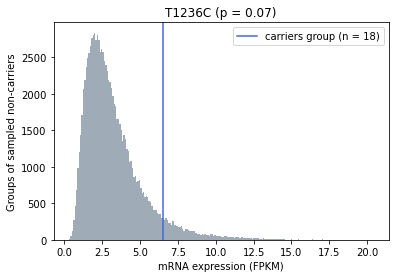

In [35]:
num_randomizations = 100000

#variant information
num_mut = 1 #T1236C
variant_name = variant_info[num_mut]["variant_name"]

patients_with_mut = patients_dict[variant_name]
mean_expression_mutated, std_expression_mutated, mean_expressions, p_value_larger = plot_expression(variant_name, patients_with_mut, expression_df, num_randomizations)
print(f"Expression of case group: {mean_expression_mutated} (std: {std_expression_mutated}).\nMean expression of control groups: {mean_expressions.mean()}")


## T2677G

Expression of case group: 3.9289591460475464 (std: 6.304107112979035).
Mean expression of control groups: 3.2531691557075013


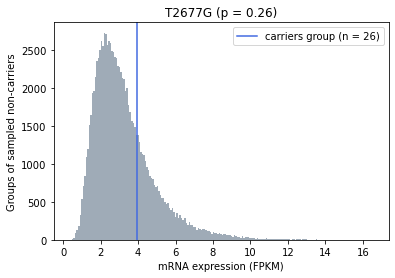

In [37]:
num_randomizations = 100000

#variant information
num_mut = 2 #T2677G
variant_name = variant_info[num_mut]["variant_name"]

patients_with_mut = patients_dict[variant_name]
mean_expression_mutated, std_expression_mutated, mean_expressions, p_value_larger = plot_expression(variant_name, patients_with_mut, expression_df, num_randomizations)
print(f"Expression of case group: {mean_expression_mutated} (std: {std_expression_mutated}).\nMean expression of control groups: {mean_expressions.mean()}")


## T3435C

Expression of case group: 3.7815917682372695 (std: 6.357498879230748).
Mean expression of control groups: 3.2507541652390017


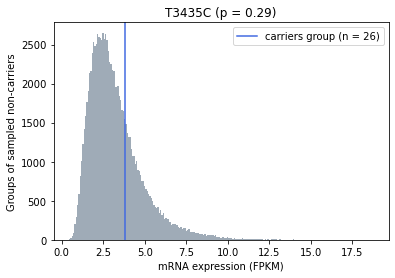

In [38]:
num_randomizations = 100000

#variant information
num_mut = 3 #T3435C
variant_name = variant_info[num_mut]["variant_name"]

patients_with_mut = patients_dict[variant_name]
mean_expression_mutated, std_expression_mutated, mean_expressions, p_value_larger = plot_expression(variant_name, patients_with_mut, expression_df, num_randomizations)
print(f"Expression of case group: {mean_expression_mutated} (std: {std_expression_mutated}).\nMean expression of control groups: {mean_expressions.mean()}")


## Haplotypes

Expression of case group: 5.977994254289399 (std: 9.544702040978764).
Mean expression of control groups: 3.255472132350525


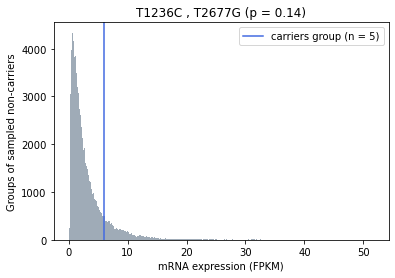

In [36]:
num_randomizations = 100000

#variant information

variant_name = "T1236C_T2677G"
patients_with_mut = patients_dict[variant_name]
mean_expression_mutated, std_expression_mutated, mean_expressions, p_value_larger = plot_expression(variant_name, patients_with_mut, expression_df, num_randomizations)
print(f"Expression of case group: {mean_expression_mutated} (std: {std_expression_mutated}).\nMean expression of control groups: {mean_expressions.mean()}")
 

Expression of case group: 4.335284158925999 (std: 8.282811311712992).
Mean expression of control groups: 3.252408924161367


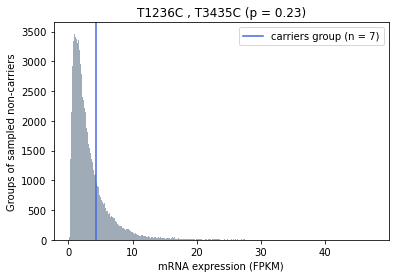

In [39]:
num_randomizations = 100000

#variant information

variant_name = "T1236C_T3435C"
patients_with_mut = patients_dict[variant_name]
mean_expression_mutated, std_expression_mutated, mean_expressions, p_value_larger = plot_expression(variant_name, patients_with_mut, expression_df, num_randomizations)
print(f"Expression of case group: {mean_expression_mutated} (std: {std_expression_mutated}).\nMean expression of control groups: {mean_expressions.mean()}")


Expression of case group: 6.235394332168875 (std: 7.77901994019132).
Mean expression of control groups: 3.274638091887676


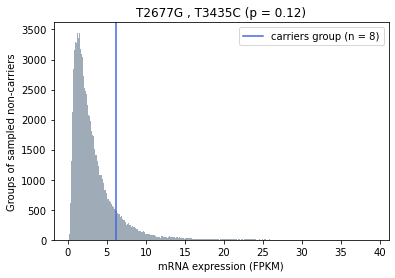

In [40]:
num_randomizations = 100000

#variant information

variant_name = "T2677G_T3435C"
patients_with_mut = patients_dict[variant_name]
mean_expression_mutated, std_expression_mutated, mean_expressions, p_value_larger = plot_expression(variant_name, patients_with_mut, expression_df, num_randomizations)
print(f"Expression of case group: {mean_expression_mutated} (std: {std_expression_mutated}).\nMean expression of control groups: {mean_expressions.mean()}")


Expression of case group: 5.977994254289399 (std: 9.544702040978764).
Mean expression of control groups: 3.2710250259907716


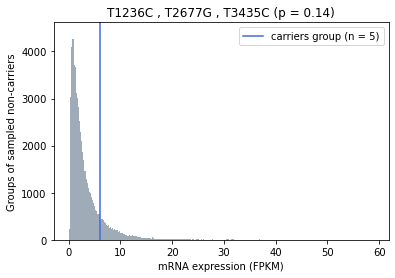

In [41]:
num_randomizations = 100000

#variant information

variant_name = "T1236C_T2677G_T3435C"
patients_with_mut = patients_dict[variant_name]
mean_expression_mutated, std_expression_mutated, mean_expressions, p_value_larger = plot_expression(variant_name, patients_with_mut, expression_df, num_randomizations)
print(f"Expression of case group: {mean_expression_mutated} (std: {std_expression_mutated}).\nMean expression of control groups: {mean_expressions.mean()}")


## Correlation or causation? 
To strengthen the hypothesis that T1236C *causes* the effect on MDR1 expression, we also check the effect of mutations correlated to it on survivability. 

In [42]:
# get the list of all mutations that patients with T1236C have. These are sorted by number of occurences. 
#for example: mut1 = 19 means that 19 out of 20 T1236C positive patients also have mut1. 

shared_muts = pd.read_pickle(f"../Data/muts_correlated_with_T1236C.pickle")
print(f"Correlated mutations:\n\n{shared_muts.head(n = 10)}")


Correlated mutations:

ENSG00000184956:chr11:1016789:1016789:T:A    19
ENSG00000184956:chr11:1016779:1016779:G:A    19
ENSG00000184956:chr11:1016800:1016800:G:A    17
ENSG00000184956:chr11:1016802:1016802:T:A    16
ENSG00000184956:chr11:1016842:1016842:T:G    15
ENSG00000184956:chr11:1016810:1016810:G:T    14
ENSG00000184956:chr11:1016818:1016818:A:G    14
ENSG00000184956:chr11:1016954:1016954:G:T    14
ENSG00000184956:chr11:1017898:1017898:T:G    13
ENSG00000184956:chr11:1016906:1016906:G:T    13
Name: mut_id, dtype: int64


In [47]:
#get only the highly correlated ones - mutations that 75% or more of T1236C positive patients have 

highly_correlated_muts = shared_muts > 15
highly_correlated_muts = highly_correlated_muts[highly_correlated_muts].index.to_list()
print(f"There are {len(highly_correlated_muts)} mutations that are present in 75% or more of T1236C positive patients:")
print(highly_correlated_muts)


There are 4 mutations that are present in 75% or more of T1236C positive patients:
['ENSG00000184956:chr11:1016789:1016789:T:A', 'ENSG00000184956:chr11:1016779:1016779:G:A', 'ENSG00000184956:chr11:1016800:1016800:G:A', 'ENSG00000184956:chr11:1016802:1016802:T:A']


In [44]:
#notice that all the correlated mutations are in MUC6, a gene that has many mutations on TCGA. 
gene_name = "MUC6"
cancer_muts_muc6 = get_cancer_muts_cur_gene(gene_name) #get TCGA mutations of MUC6


/tamir1/tal_g/ENV/co-trans/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (19,20,21,22,28) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/tamir1/tal_g/ENV/co-trans/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (118) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/tamir1/tal_g/ENV/co-trans/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (19,20,21,22,28,118) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


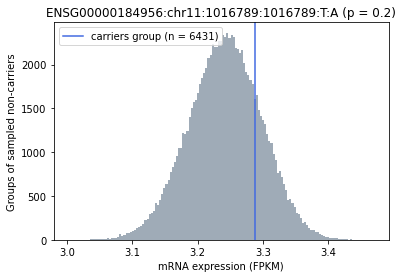

Expression of case group: 3.28859251331439 (std: 8.646405350662967).
Mean expression of control groups: 3.2419986215265233


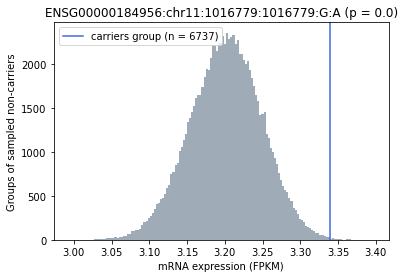

Expression of case group: 3.3390173616468606 (std: 8.807601758793744).
Mean expression of control groups: 3.201391120885785


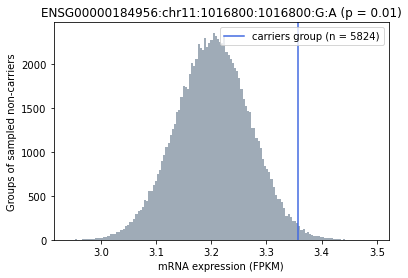

Expression of case group: 3.357116067500869 (std: 8.923658381219383).
Mean expression of control groups: 3.2033713177856944


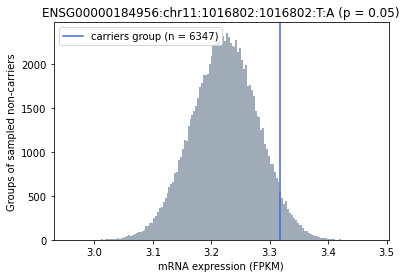

Expression of case group: 3.3168428689882323 (std: 8.820716371832226).
Mean expression of control groups: 3.223044376507547


In [68]:
num_randomizations = 100000

mutated_exp = []
nonmutated_exp = []

for mut_id in highly_correlated_muts:
    
    gene_id, chrom, start_pos, end_pos, ref, alt = mut_id.split(":") #get info of the variant

    cur_position = cancer_muts_muc6['Start_Position'] == int(start_pos)
    cur_alt = cancer_muts_muc6["Tumor_Seq_Allele2"] == alt
    patients_with_this_mut = cancer_muts_muc6[cur_position & cur_alt]["case_id"].unique() #get patients with this variant
    
    #check the expression levels of case and control groups. plot it. 
    mean_expression_mutated, std_expression_mutated, mean_expressions, p_value_larger = plot_expression(mut_id, patients_with_this_mut, expression_df, num_randomizations)
    print(f"Expression of case group: {mean_expression_mutated} (std: {std_expression_mutated}).\nMean expression of control groups: {mean_expressions.mean()}")

    mutated_exp.append(mean_expression_mutated)
    nonmutated_exp.append(mean_expressions.mean())


In [69]:
fold_exp = np.array(mutated_exp) / np.array(nonmutated_exp)

In [70]:
np.max(fold_exp)

1.0479946701344163

In [71]:
np.min(fold_exp)

1.0143719653298087